In [39]:
import pandas as pd
import bioframe
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cooler

In [27]:
pd.set_option('display.max_rows', 500)

In [7]:
organism = 'dicty'
df_genes = pd.read_csv('../../GENOME/dictybase_gene_coordinates.txt', sep='\t', header=None)
df_genes.columns = ['chrom', 'start', 'end', 'strand', 'name']
df_genes.loc[:, 'length'] = (df_genes.end-df_genes.start)
df_genes = df_genes.sort_values(['chrom', 'start', 'end']).reset_index(drop=True)
df_chromsizes = pd.read_csv('../../GENOME/dicty_chromsizes.txt', sep='\t', header=None)

In [35]:
df_expression = pd.read_csv('../../RNASEQ/mapping_tsoi/all_gene_markdup_htseq', 
                            sep='\t', header=None)
df_expression.columns = ['name', '0A', '0B', '2A', '2B', '5A', '5B', '8A', '8B']

for f in glob.glob('../../RNASEQ/mapping_tsoi/difexpr/ed*'):
    df_tmp = pd.read_csv(f, sep='\t', header=None)
    pref = '_'.join( f.split('/')[-1].split('.')[0].split('_')[2:5] )
    df_tmp.columns = ['chrom', 'name', 'start', 'end', 'strand', f'score_{pref}']
    df_expression = df_expression.merge(df_tmp[['name', f'score_{pref}']], on=['name'], how='outer')
    
df_expression = pd.merge(df_expression, df_genes, on='name', how='outer').dropna(subset=['chrom', 'start', 'end'])
df_expression.loc[:, 'length'] = (df_expression.end-df_expression.start)

for rep in ['0A', '0B', '2A', '2B', '5A', '5B', '8A', '8B']:
    df_expression.loc[:, f'rpkm_{rep}'] = 1e6*1e3*df_expression[f'{rep}']/np.sum(df_expression[f'{rep}'])/df_expression['length']

df_expression.loc[:, 'expr_0h'] = df_expression.loc[:, 'rpkm_0A'] + df_expression.loc[:, 'rpkm_0B']
df_expression.loc[:, 'expr_2h'] = df_expression.loc[:, 'rpkm_2A'] + df_expression.loc[:, 'rpkm_2B']
df_expression.loc[:, 'expr_5h'] = df_expression.loc[:, 'rpkm_5A'] + df_expression.loc[:, 'rpkm_5B']
df_expression.loc[:, 'expr_8h'] = df_expression.loc[:, 'rpkm_8A'] + df_expression.loc[:, 'rpkm_8B']

df_expression[['start', 'end']] = df_expression[['start', 'end']].astype(int)

# df_expression.loc[:, 'gene_start'] = np.where(df_expression.strand=="+", df_expression.start, df_expression.end)
# df_expression.loc[:, 'gene_end'] = np.where(df_expression.strand=="+", df_expression.end, df_expression.start)

# df_expression.loc[:, 'start'] = df_expression.loc[:, 'gene_start']
# df_expression.loc[:, 'end'] = df_expression.loc[:, 'gene_end']

df_expression = df_expression[[
    'chrom', 'start', 'end', 'strand', 'length', 'name', 
    'expr_0h', 'expr_2h', 'expr_5h', 'expr_8h',
    'rpkm_0A', 'rpkm_0B', 'rpkm_2A', 'rpkm_2B', 'rpkm_5A', 'rpkm_5B', 'rpkm_8A', 'rpkm_8B',
    '0A', '0B', '2A', '2B', '5A', '5B', '8A', '8B',
    'score_two_vs_zero', 'score_five_vs_two', 'score_five_vs_zero', 'score_eight_vs_two', 'score_eight_vs_zero', 'score_eight_vs_five',
]]

/home/agalicina/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='expr_0h', ylabel='Density'>

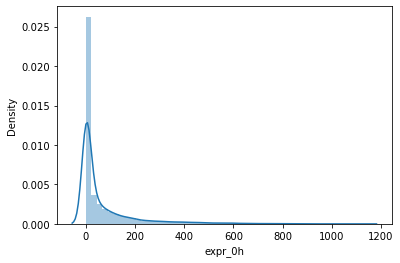

In [40]:
sns.distplot(df_expression.expr_0h)

In [93]:
bottom_th = np.percentile(df_expression.expr_0h, 50)
bottom_th

9.55080696165906

In [291]:
start = 3000000
end = 3250000
chrom = "chr1"
df_selected = bioframe.select(df_expression, f"{chrom}:{start}-{end}")\
  .query(f"expr_0h>{bottom_th}").sort_values('start').reset_index(drop=True)

(-10.0, 10.0)

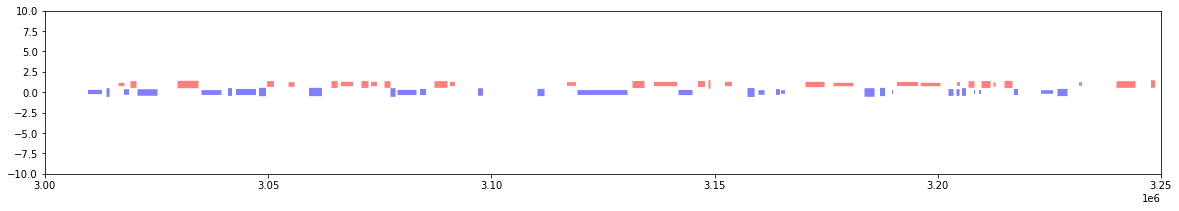

In [292]:
# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/joinstyle.html#cap-styles

plt.figure(figsize=[20,3])
for i, r in df_selected.iterrows():
    color = 'r' if r.strand=="+" else 'b'
    ypos = 1 if r.strand=="+" else 0
    plt.plot([r.start, r.end], [ypos, ypos], color=color, solid_capstyle='butt', alpha=0.5, linewidth=np.log2(r.expr_0h))
    
    
plt.xlim(start, end)
plt.ylim(-10,10)

In [293]:
len(df_selected)

61

In [300]:
binsize = 250
#offset = 261

df_selected.loc[:, 'start_bin'] = df_selected.start//binsize - start//binsize #- min(df_selected.start)//binsize + offset
df_selected.loc[:, 'end_bin']   = df_selected.end//binsize   - start//binsize # - min(df_selected.start)//binsize + offset


In [316]:
end//binsize - start//binsize

1000

In [301]:
# vm = np.max(np.log10(df_selected.expr_0h))
# df_selected.loc[:, "norm_expr"] = np.log10(df_selected.expr_0h)/vm

vm = np.mean(df_selected.expr_0h)
df_selected.loc[:, "norm_expr"] = df_selected.expr_0h/vm

In [302]:
def validate_overlaps(starts, ends):
    starts = np.array(starts)
    ends = np.array(ends)
    starts_next = np.roll(starts, 1)
    
    errors = np.where(ends<=starts_next)[0]
    assert errors.shape==(1,), f"Problem at: {errors[1:]}"
    
    return ends, starts_next

In [303]:
ends, starts_next = validate_overlaps(df_selected.start_bin, df_selected.end_bin)

In [304]:
df_selected.loc[:, 'gene_start'] = np.where(df_selected.strand=="+", df_selected.start_bin, df_selected.end_bin)
df_selected.loc[:, 'gene_end']   = np.where(df_selected.strand=="+", df_selected.end_bin,   df_selected.start_bin)
df_selected.loc[:, 'gene_size']  = np.abs(df_selected.gene_start-df_selected.gene_end)

In [305]:
df_selected[['gene_start', 'gene_end', 'norm_expr', 'gene_size', 'strand', 'start', 'end']].head(10)

,gene_start,gene_end,norm_expr,gene_size,strand,start,end
0,51,38,0.185201,13,-,3009708,3012882
1,57,54,3.879881,3,-,3013601,3014302
2,65,70,0.087748,5,+,3016390,3017663
3,75,70,0.431692,5,-,3017741,3018878
4,76,81,1.028104,5,+,3019090,3020441
5,100,82,0.843344,18,-,3020703,3025206
6,118,136,1.563322,18,+,3029557,3034180
7,158,139,0.258159,19,-,3034894,3039544
8,167,164,2.012170,3,-,3041058,3041915
9,189,171,0.628040,18,-,3042784,3047317


In [306]:
df_selected[['gene_start', 'gene_end', 'norm_expr', 'gene_size', 'strand', 'start', 'end']].tail(10)

,gene_start,gene_end,norm_expr,gene_size,strand,start,end
51,838,836,0.125070,2,-,3209191,3209706
52,838,846,1.107134,8,+,3209615,3211648
53,849,851,0.239649,2,+,3212380,3212770
54,859,866,1.350232,7,+,3214845,3216721
55,872,868,0.651044,4,-,3217078,3218041
56,903,892,0.111907,11,-,3223232,3225869
57,916,906,1.345884,10,-,3226604,3229060
58,926,929,0.108922,3,+,3231552,3232417
59,959,976,0.924659,17,+,3239824,3244143
60,991,995,1.727197,4,+,3247871,3248759


/home/agalicina/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 15.0)

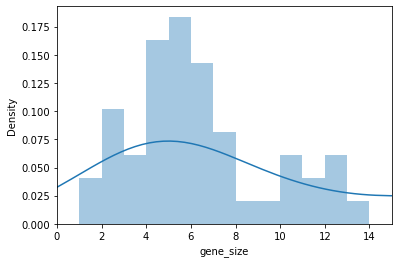

In [307]:
sns.distplot( df_selected.gene_size, bins=np.arange(0,15,1))
plt.xlim(0,15)

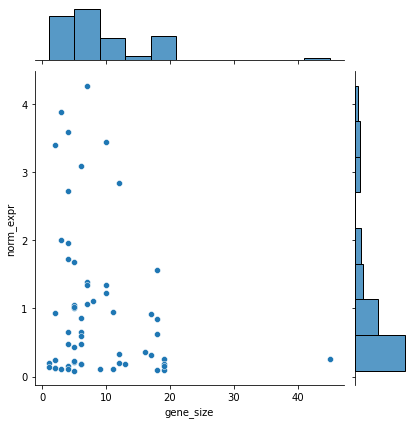

In [308]:
sns.jointplot(data=df_selected, x="gene_size", y="norm_expr")

In [309]:
df_selected[['gene_start', 'gene_end', 'norm_expr', 'strand']].tail(5)

,gene_start,gene_end,norm_expr,strand
56,903,892,0.111907,-
57,916,906,1.345884,-
58,926,929,0.108922,+
59,959,976,0.924659,+
60,991,995,1.727197,+


In [312]:
print( ','.join(df_selected.gene_start.astype('str').values) )

51,57,65,75,76,100,118,158,167,189,198,199,217,248,256,264,282,291,303,313,332,341,348,363,392,447,467,521,526,546,579,585,594,609,635,644,658,663,681,705,743,752,759,763,783,813,818,817,825,826,833,838,838,849,859,872,903,916,926,959,991


In [313]:
print( ','.join(df_selected.gene_end.astype('str').values) )

38,54,70,70,81,82,136,139,164,171,192,205,222,236,261,276,289,297,308,309,315,335,359,367,387,440,476,476,536,565,567,591,596,615,628,639,654,659,697,724,733,748,758,782,801,808,816,819,821,832,832,836,846,851,866,868,892,906,929,976,995


In [314]:
print( ','.join([f"{x:.2f}" for x in df_selected.norm_expr.values]) )

0.19,3.88,0.09,0.43,1.03,0.84,1.56,0.26,2.01,0.63,3.09,0.48,0.21,2.84,1.06,0.20,1.07,0.19,1.00,3.60,0.32,0.65,0.95,0.16,1.68,1.40,0.11,0.26,1.23,0.19,0.33,0.59,3.40,0.19,4.27,0.23,0.48,0.11,0.37,0.10,3.44,2.73,0.20,0.16,0.10,1.02,0.94,0.12,1.96,0.86,0.15,0.13,1.11,0.24,1.35,0.65,0.11,1.35,0.11,0.92,1.73


In [ ]:
### Final set of commands:

python 00_1D_simulation.py -v -o data/traj1d/test-full.h5py \
  --pol-loading 51,57,65,75,76,100,118,158,167,189,198,199,217,248,256,264,282,291,303,313,332,341,348,363,392,447,467,521,526,546,579,585,594,609,635,644,658,663,681,705,743,752,759,763,783,813,818,817,825,826,833,838,838,849,859,872,903,916,926,959,991 \
  --pol-termination 38,54,70,70,81,82,136,139,164,171,192,205,222,236,261,276,289,297,308,309,315,335,359,367,387,440,476,476,536,565,567,591,596,615,628,639,654,659,697,724,733,748,758,782,801,808,816,819,821,832,832,836,846,851,866,868,892,906,929,976,995 \
  --pol-kin-loading 0.19,3.88,0.09,0.43,1.03,0.84,1.56,0.26,2.01,0.63,3.09,0.48,0.21,2.84,1.06,0.20,1.07,0.19,1.00,3.60,0.32,0.65,0.95,0.16,1.68,1.40,0.11,0.26,1.23,0.19,0.33,0.59,3.40,0.19,4.27,0.23,0.48,0.11,0.37,0.10,3.44,2.73,0.20,0.16,0.10,1.02,0.94,0.12,1.96,0.86,0.15,0.13,1.11,0.24,1.35,0.65,0.11,1.35,0.11,0.92,1.73 \
  -D 1000 -R 10 -N 1000 --pol-kin 0.1 \
  --lef-unstall-rate 0.00125 -L 400 -S 400 # lifetime is 100 Kb and sep is 1000 Kb; lef unstall is 1/(2*lifetime)
  

python ../01_3D_simulations.py -v -i data/traj1d/test-full.h5py -o data/traj3d/test-full/ -G 0

python ../02_2D_contactmap.py -v -f -i data/traj3d/test-full/ -o data/maps2d/test.npy -N 1000 -R 10